# Setup

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import torch
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
import sys
sys.path.append("../../..")
from src.models import training_utils,base_model,sage_ones

data_folder = "../../../data/processed/graph_data_nohubs/merged_types/"
experiments_folder = "../../../data/experiments/design_space_merged_experiment/seed_0/"
reports_folder = "../../../reports/explore_predictions/"

# Load a pretrained model

In [2]:
results = pd.read_parquet(experiments_folder+"experiment_16_06_23__17_59_43.parquet")

node_csv = pd.read_csv(data_folder+"merged_nodes.csv")
node_info = pd.read_csv(data_folder+"merged_node_info.csv")
edge_data = pd.read_csv(data_folder+"merged_edges.csv")

datasets, node_map = training_utils.load_data(data_folder+"split_dataset/seed_0/")
train_data, val_data = datasets

new_datasets, new_node_map = training_utils.load_data(data_folder+"split_dataset/seed_4/")
new_train_data, new_val_data = new_datasets

In [3]:
df = pd.read_csv(data_folder+"split_dataset/seed_4/tensor_df.csv",index_col=0).set_index("node_index",drop=True)

In [4]:
results.sort_values(by="auc",ascending=False)

,L2_norm,batch_norm,conv_type,delta,dropout,epochs,experiment_name,feature_dim,feature_type,heads,...,micro_aggregation,msg_passing_layers,normalize_output,patience,post_process_layers,pre_process_layers,supervision_types,weight_decay,auc,curve_data
62,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909951,"[[0.703677773475647, 0.6893664002418518, 0.676..."
55,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,3,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909892,"[[0.6917510628700256, 0.6621622443199158, 0.63..."
54,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909118,"[[0.6860914826393127, 0.6716712117195129, 0.65..."
59,True,True,SAGEConv,0.1,0.1,400,layers_connectivity,10,ones,2,...,sum,3,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.909058,"[[0.6657952666282654, 0.6534611582756042, 0.64..."
9,True,True,SAGEConv,0.1,0.1,400,sage_aggr_type,10,ones,2,...,sum,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.908880,"[[0.6850339770317078, 0.6739553809165955, 0.66..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,True,True,SAGEConv,0.1,0.1,400,GAT_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.821747,"[[0.691173255443573, 0.6777836084365845, 0.665..."
17,True,True,SAGEConv,0.1,0.1,400,sage_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.816867,"[[0.7043997645378113, 0.6885340809822083, 0.67..."
14,True,True,SAGEConv,0.1,0.1,400,sage_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.815617,"[[0.6883745789527893, 0.6758227944374084, 0.66..."
35,True,True,SAGEConv,0.1,0.1,400,GAT_aggr_type,10,ones,2,...,max,2,False,10,1,0,"[[gene_protein, gda, disease]]",0.001,0.797107,"[[0.6960344910621643, 0.6834494471549988, 0.67..."


In [5]:
def load_model(weights_path,supervision_types,metadata,model_args=None):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    weights = torch.load(weights_path,map_location=torch.device(device))
    model = base_model.base_model(model_args,metadata,supervision_types)
    model.load_state_dict(weights)

    return model

In [6]:
model_params = ['hidden_channels', 'conv_type', 'batch_norm', 'dropout', 'micro_aggregation', 'macro_aggregation', 'layer_connectivity', 'L2_norm', 'pre_process_layers', 'msg_passing_layers', 'post_process_layers', 'normalize_output', 'jumping_knowledge']
eid = 62
params = results[model_params].loc[eid].to_dict()
weights_path = experiments_folder+"model_62_16_06_23__17_59_43.pth"

old_model = load_model(weights_path,[("gene_protein","gda","disease")],train_data.metadata(),params)

In [7]:
weights_path = "../../../data/experiments/merged_types_experiment/sage_ones_first_negatives_exp_04_07_23__12_07.pth"
weights = torch.load(weights_path)
new_model = sage_ones.Model(train_data.metadata(),[("gene_protein","gda","disease")])
new_model.load_state_dict(weights)

feature_type = "ones"
feature_dim = 10

train_data = training_utils.initialize_features(train_data, feature_type, feature_dim)
val_data = training_utils.initialize_features(val_data, feature_type, feature_dim)

new_train_data = training_utils.initialize_features(new_train_data, feature_type, feature_dim)
new_val_data = training_utils.initialize_features(new_val_data, feature_type, feature_dim)

# Get encodings

In [8]:
# feature_type = results.loc[eid,"feature_type"]
# feature_dim  = results.loc[eid,"feature_dim"]
# val_data = training_utils.initialize_features(val_data, feature_type, feature_dim)

In [8]:
old_encodings = training_utils.get_encodings(old_model,val_data)
new_encodings = training_utils.get_encodings(new_model,new_val_data)

# Prioritize

In [9]:
class inner_product_decoder(torch.nn.Module):
    def forward(self,x_source,x_target,apply_sigmoid=True):
        pred = (x_source * x_target).sum(dim=1)

        if apply_sigmoid:
            pred = torch.sigmoid(pred)

        return pred

In [10]:
def prioritize(node_index,encodings_dict,node_df):
    assert df.index.name == "node_index", f"df index must be node_index, not {df.index.name}."

    decoder = inner_product_decoder()
    source_type = node_df.loc[node_index,"node_type"]
    tensor_index = node_df.loc[node_index,"tensor_index"]

    if source_type == "disease":
        target_type = "gene_protein"

    elif source_type == "gene_protein":
        target_type = "disease"

    source_vector = encodings_dict[source_type][tensor_index]
    target_matrix = encodings_dict[target_type]

    predicted_edges = decoder(source_vector,target_matrix)
    ranked_scores, ranked_indices = torch.sort(predicted_edges,descending=True)
    results = pd.DataFrame({"score":ranked_scores.cpu().numpy(),"tensor_index":ranked_indices.cpu().numpy()})
    results.score = results.score.round(3)

    index_map = df.loc[df.node_type == target_type,["tensor_index","node_name","degree_gda"]].reset_index()
    ranked_predictions = pd.merge(results,index_map,on="tensor_index")
    ranked_predictions.index.name = "rank"

    return ranked_predictions

In [11]:
df.sort_values(by="degree_dd",ascending=False)[:20]

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
9958,5113_5550_5108,infectious disease,disease,primekg,3940,359.0,33.0,0.0,0.0,98.0,98.0
3072,14866_12012_33850_11890_11687_12014_13758_1156...,Charcot-Marie-Tooth disease,disease,primekg,3605,382.0,57.0,0.0,0.0,90.0,90.0
865,10632_33369_33371_10472_14477_32598_10396_3276...,developmental and epileptic encephalopathy,disease,primekg,1730,184.0,38.0,0.0,0.0,80.0,80.0
2788,14302_12928_14568_12867_12766_13132_13239_1148...,hereditary spastic paraplegia,disease,primekg,5867,379.0,37.0,0.0,0.0,78.0,78.0
2421,13274_10761_10945_8378_12796_910_11272_13611_1...,retinitis pigmentosa,disease,primekg,4127,332.0,54.0,0.0,0.0,76.0,76.0
5438,24623_18751,otorhinolaryngologic disease,disease,primekg,1899,220.0,24.0,0.0,0.0,75.0,75.0
2818,14376_13657_54837_30918_20847_13820_14486_1380...,"intellectual disability, autosomal dominant",disease,primekg,4268,77.0,41.0,0.0,0.0,72.0,72.0
1315,11160_13119_13978_12060_12327_12670_13210_1106...,autosomal recessive nonsyndromic deafness,disease,primekg,2547,745.0,58.0,0.0,0.0,68.0,68.0
20104,C0025521,Inborn Errors of Metabolism,disease,disgenet,314,271.0,39.0,17.0,0.0,67.0,84.0


In [12]:
def tensor_to_edgelist(tensor: torch.tensor):
    sources = tensor[0,:].tolist()
    targets = tensor[1,:].tolist()
    edgelist = list(zip(sources,targets))
    return edgelist

def reverse_map(node_map,edge_list,edge_type):
    """Maps edge dictionary from pyg Heterodata back into the original node indexes from the dataframe"""
    src_map = {v:k for k,v in node_map[edge_type[0]].items()}
    dst_map = {v:k for k,v in node_map[edge_type[2]].items()}
    mapped_edge_list = [(src_map[n1],dst_map[n2]) for (n1,n2) in edge_list]

    return mapped_edge_list

def inverse_map_heterodata(data,node_map):
    """Maps full edge data from pyg Heterodata back into the original node indexes from the dataframe"""
    edge_dict = {}
    for edge_type in data.edge_types:
        type_dict = {}
        edge_tensor = data[edge_type]["edge_index"]
        edge_list = tensor_to_edgelist(edge_tensor)
        mapped_edge_list = reverse_map(node_map,edge_list,edge_type)

        type_dict["message_passing_edges"] = mapped_edge_list

        if "edge_label_index" in data[edge_type].keys():
            labeled_edges_tensor = data[edge_type]["edge_label_index"]
            labeled_edges_list = tensor_to_edgelist(labeled_edges_tensor)
            mapped_labeled_edges_list = reverse_map(node_map,labeled_edges_list,edge_type)

            edge_labels = data[edge_type]["edge_label"].tolist()

            type_dict["supervision_edges"] = mapped_labeled_edges_list
            type_dict["supervision_labels"] = edge_labels
 
        edge_dict[edge_type] = type_dict
    
    return edge_dict

def edge_map_to_df(inverse_map_dict):
    edges_df = {}
    for edge_type,sub_dict in inverse_map_dict.items():
        if "supervision_edges" in sub_dict.keys():
            edges = pd.DataFrame(sub_dict["supervision_edges"]).rename(columns={0:edge_type[0],1:edge_type[2]})
            edge_labels_df = pd.concat([edges,pd.DataFrame(sub_dict["supervision_labels"])],axis=1).rename(columns={0:"label"})

            msg_passing_edges_df = pd.DataFrame(sub_dict["message_passing_edges"]).rename(columns={0:edge_type[0],1:edge_type[2]})

            edges_df[edge_type] = {"supervision_edges":edge_labels_df,"message_passing_edges":msg_passing_edges_df}
    
    return edges_df

def get_full_edge_df(train_data,val_data,node_map,edge_type = ("gene_protein","gda","disease")):
    train_dataframes = edge_map_to_df(inverse_map_heterodata(train_data,node_map))[edge_type]
    val_dataframes = edge_map_to_df(inverse_map_heterodata(val_data,node_map))[edge_type]

    train_df = pd.concat([df for df in train_dataframes.values()])
    train_df["edge_subtype"] = train_df.fillna(-1).label.apply(lambda x: "supervision" if x >= 0 else "message_passing")
    train_df["dataset"] = "train"


    val_df = pd.concat([df for df in val_dataframes.values()])
    val_df["edge_subtype"] = val_df.fillna(-1).label.apply(lambda x: "supervision" if x >= 0 else "message_passing")
    val_df["dataset"] = "validation"

    full_df = pd.concat([train_df,val_df])
    return full_df


def test_mapping(full_df, original_edge_data, edge_type = ("gene_protein","gda","disease")):
    original_edges = original_edge_data[(original_edge_data.x_type == edge_type[0]) & (original_edge_data.edge_type == edge_type[1])][["x_index","y_index"]]
    test_df = full_df[(full_df.label == 1) | (full_df.edge_subtype == "message_passing")][[edge_type[0],edge_type[2]]].drop_duplicates().rename(columns={edge_type[0]:"x_index",edge_type[2]:"y_index"})
    both, left, right = pd.merge(test_df, original_edges, how="inner", indicator=True)._merge.value_counts()
    print(both == len(test_df), left == 0, right == 0)

In [13]:
def hits_at_k(node_index,predictions,edge_df,df=df):
      k_list = [5,10,50,100]

      node_type = df.loc[node_index,"node_type"]
      y_type = "disease" if node_type == "gene_protein" else "gene_protein"

      new_edges = set(edge_df[(edge_df[node_type] == node_index) & (edge_df.label == 1) & (edge_df.dataset == "validation")][y_type].values)
      seen_edges = set(edge_df[(edge_df[node_type] == node_index)][y_type].values) - new_edges

      results = {"seen_edges":len(seen_edges),"new_edges":len(new_edges)}

      for k in k_list:
            predicted_top = set(predictions[:k]["node_index"].values)

            seen_hits = len(seen_edges.intersection(predicted_top))
            new_hits = len(new_edges.intersection(predicted_top))

            results[f"{k}_seen"] = seen_hits
            results[f"{k}_new"] = new_hits

      return results

In [14]:
encodings = new_encodings
dataset = new_val_data

node_index = 20104
print(df.loc[node_index,"node_name"], df.loc[node_index,"degree_gda"])
predictions = prioritize(node_index,encodings,df)

Inborn Errors of Metabolism 17.0


In [15]:
predictions

,score,tensor_index,node_index,node_name,degree_gda
rank,,,,,
0,0.692,14368,7678,IFNA2,170.0
1,0.692,10645,3387,CYP17A1,49.0
2,0.690,16402,13803,SMO,59.0
3,0.689,15031,10518,PLAU,109.0
4,0.688,14056,11826,PRL,97.0
...,...,...,...,...,...
17738,0.119,12657,6865,THYN1,3.0
17739,0.119,6728,1130,PNRC1,6.0
17740,0.119,1855,349,FRY,5.0


In [16]:
old_full_df = get_full_edge_df(train_data,val_data,node_map)
new_full_df = get_full_edge_df(new_train_data,new_val_data,node_map)

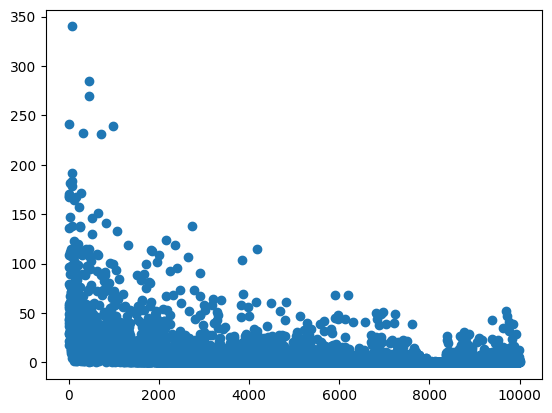

In [17]:
cut = 10000
plt.scatter(predictions[:cut].index.values, predictions[:cut].degree_gda.values)

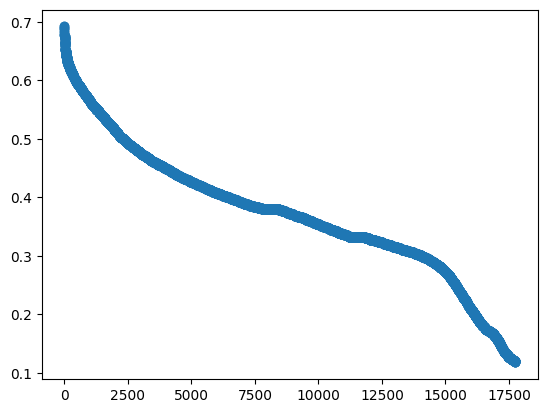

In [95]:
plt.scatter(predictions.index,predictions.score)

In [17]:
disease_evals = {}
for disease in tqdm(df[df.node_type == "disease"].index.values):
    predictions = prioritize(disease, new_encodings,df)
    disease_evals[disease] = hits_at_k(disease,predictions,new_full_df)

100%|██████████| 16079/16079 [04:59<00:00, 53.74it/s]


In [19]:
gene_evals = {}
for gene in tqdm(df[df.node_type == "gene_protein"].index.values):
    predictions = prioritize(gene, new_encodings,df)
    gene_evals[gene] = hits_at_k(gene,predictions,new_full_df)

100%|██████████| 17743/17743 [05:42<00:00, 51.76it/s]


In [20]:
total_disease_evals = pd.DataFrame(disease_evals).T
cols = total_disease_evals.columns
total_disease_evals = total_disease_evals.merge(df["node_name"],left_index=True,right_index=True)[["node_name",*cols]]

total_gene_evals = pd.DataFrame(gene_evals).T
cols = total_gene_evals.columns
total_gene_evals = total_gene_evals.merge(df["node_name"],left_index=True,right_index=True)[["node_name",*cols]]

In [104]:
k_list = [5,10,50,100]
summary_disease_evals = pd.DataFrame()
for k in k_list:
    summary_disease_evals[f"hits_{k}"] = total_disease_evals[f"{k}_new"] + total_disease_evals[f"{k}_seen"]

cols = summary_disease_evals.columns
add_cols=["node_name","degree_gda","degree_dd","comunidades_infomap","comunidades_louvain"]
summary_disease_evals = pd.merge(summary_disease_evals,df[add_cols],left_index=True,right_index=True)[[*add_cols,*cols]]

summary_gene_evals = pd.DataFrame()
for k in k_list:
    summary_gene_evals[f"hits_{k}"] = total_gene_evals[f"{k}_new"] + total_gene_evals[f"{k}_seen"]

cols = summary_gene_evals.columns
add_cols = ["node_name","degree_gda","degree_pp"]
summary_gene_evals = pd.merge(summary_gene_evals,df[add_cols],left_index=True,right_index=True)[[*add_cols,*cols]]

total_disease_evals = total_disease_evals.merge(summary_disease_evals["degree_gda"],left_index=True,right_index=True)
total_gene_evals = total_gene_evals.merge(summary_gene_evals["degree_gda"],left_index=True,right_index=True)

In [57]:
total_disease_evals.sort_values(by="10_seen",ascending=False)[:20]

,node_name,seen_edges,new_edges,5_seen,5_new,10_seen,10_new,50_seen,50_new,100_seen,100_new
24470,Vertiginous seizure,93,13,5,0,9,0,21,4,43,8
23154,Epileptic drop attack,92,6,5,0,9,0,23,1,49,1
23153,Tonic Seizures,92,9,5,0,9,0,25,2,45,5
25419,"Seizures, Sensory",91,8,5,0,9,0,25,2,50,2
32504,Convulsions,104,6,5,0,9,0,26,3,50,3
20778,Seizures,190,21,4,1,9,1,39,2,54,5
24469,Gustatory seizure,90,13,5,0,9,0,23,2,44,7
33264,Epileptic Seizures,93,10,4,1,8,1,24,3,45,6
25417,Convulsive Seizures,88,14,4,0,8,0,22,3,44,5
33266,Myoclonic Seizures,84,17,4,0,8,0,24,2,41,6


In [37]:
def save_hits_df(model_name,desc,disease_total,disease_summary,gene_total,gene_summary,reports_folder=reports_folder):
    disease_total.to_csv(reports_folder+model_name+"_total_disease.csv")
    disease_summary.to_csv(reports_folder+model_name+"_summary_disease.csv")
    gene_summary.to_csv(reports_folder+model_name+"_summary_gene.csv")
    gene_total.to_csv(reports_folder+model_name+"_total_gene.csv")

    with open(reports_folder+model_name+"_desc.txt", "w") as f:
        f.write(desc)

def load_hits_df(model_name,reports_folder=reports_folder):
    fnames = ["_total_disease.csv","_summary_disease.csv","_summary_gene.csv","_total_gene.csv"]
    dfs = []
    for fname in fnames:
        dfs.append(pd.read_csv(reports_folder+model_name+fname,index_col=0))
    return dfs

In [105]:
model_name = "sage_ones_first_negatives_exp_04_07_23__12_07"
desc = "El mismo sage ones que probamos con 0.9 AUC, pero con neg sampling. Seed 4"

save_hits_df(model_name,desc,total_disease_evals,summary_disease_evals,total_gene_evals,summary_gene_evals)

Hacer un bineo de nivel de evidencia y mostrar el promedio de los hits a diferentes k (conservar la separación entre seen y new). TAmbién grado disease-disease.
tomar seen-new-total 5-10-50.
Boxplot.

In [129]:
import numpy as np

def group_by_size(data_df,group_column,num_groups,max_log):
    df = data_df.copy()
    spacing = np.logspace(1,max_log,num=num_groups).round().astype(int)
    bins = np.digitize(df[group_column].values, spacing)
    df["bins"] = bins

    bin_ranges = []
    for bin in range(num_groups):
        bin_min = df[df.bins == bin].degree_gda.min()
        bin_max = df[df.bins == bin].degree_gda.max()
        bin_ranges.append((int(bin_min),int(bin_max)))

    return df, bin_ranges

In [132]:
aver, ranges = group_by_size(total_disease_evals[total_disease_evals.degree_gda != 0],"degree_gda",3,4)

In [156]:
aver.bins.value_counts()

0    9802
1    1345
2      19
Name: bins, dtype: int64

In [134]:
ranges

[(1, 9), (10, 300), (404, 1074)]

In [158]:
fig = px.histogram(total_disease_evals[total_disease_evals.degree_gda!=0].astype({"degree_gda":int}),"degree_gda",log_y=True)
fig.show()

In [135]:
import plotly.express as px
fig = px.box(aver, y = "50_seen",x="bins")
fig.show()

In [65]:
summary_disease_evals.sort_values(by="hits_10",ascending=False)[50:70]

,node_name,degree_gda,degree_dd,comunidades_infomap,comunidades_louvain,hits_5,hits_10,hits_50,hits_100
18975,Colonic Neoplasms,152.0,5.0,624.0,3.0,1,5,16,24
22276,"Pain, Burning",49.0,0.0,NaN,NaN,2,5,16,22
20391,Pain,49.0,0.0,NaN,NaN,2,5,16,25
19732,Hypotension,53.0,2.0,74.0,23.0,2,5,13,22
25377,"Pain, Migratory",49.0,0.0,NaN,NaN,2,5,15,22
20890,Streptozotocin Diabetes,108.0,0.0,NaN,NaN,4,5,18,24
26108,"Mammary Carcinoma, Animal",142.0,0.0,NaN,NaN,3,5,9,17
20209,Necrosis,55.0,0.0,NaN,NaN,4,5,10,12
20028,Malignant neoplasm of stomach,300.0,5.0,24.0,3.0,3,5,15,27
20030,Animal Mammary Neoplasms,142.0,0.0,NaN,NaN,2,5,10,16


In [24]:
summary_gene_evals.sort_values(by="hits_5",ascending=False)[:20]

,node_name,degree_gda,degree_pp,hits_5,hits_10,hits_50,hits_100
6931,GSTA4,10.0,4.0,5,8,8,8
1846,CLU,66.0,54.0,5,10,17,19
9227,MST1,20.0,2.0,5,6,7,11
9192,MIR338,13.0,0.0,5,9,13,13
8730,MIR130A,14.0,0.0,5,8,11,11
16173,CASP8,58.0,71.0,5,8,12,23
9667,OPRM1,109.0,70.0,5,6,23,32
8816,MIR30A,26.0,0.0,5,8,16,20
153,MIR1247,9.0,0.0,5,6,7,9
3206,CCDC80,8.0,0.0,5,6,6,6


# AUCs para predicciones individuales 

In [25]:


# node_index = 25249	
# preds = prioritize(node_index,encodings,df)
# testing_edges = new_full_df[(new_full_df.dataset == "validation") & (new_full_df.disease == node_index) & (new_full_df.edge_subtype == "supervision")][["gene_protein","label"]]
# scores = preds.merge(testing_edges, left_on="node_index",right_on="gene_protein",how="right")[["score","label"]]
# auc = round(roc_auc_score(scores.label.values,scores.score.values),3)

disease_evals = {}
for node_index in tqdm(df[df.node_type == "disease"].index.values):
    preds = prioritize(node_index,encodings,df)
    testing_edges = new_full_df[(new_full_df.dataset == "validation") & (new_full_df.disease == node_index) & (new_full_df.edge_subtype == "supervision")][["gene_protein","label"]]
    if len(testing_edges) != 0:
        if len(testing_edges.label.unique()) > 1:
            scores = preds.merge(testing_edges, left_on="node_index",right_on="gene_protein",how="right")[["score","label"]]
            auc = round(roc_auc_score(scores.label.values,scores.score.values),3)
            pos,neg = scores.label.value_counts()
            balance = pos/neg
            disease_evals[node_index] = {"auc":auc, "num_samples":len(scores), "balance":balance}


  0%|          | 0/16079 [00:00<?, ?it/s]

100%|██████████| 16079/16079 [08:42<00:00, 30.79it/s]


In [35]:
gene_evals = {}
for node_index in tqdm(df[df.node_type == "gene_protein"].index.values):
    preds = prioritize(node_index,encodings,df)
    testing_edges = new_full_df[(new_full_df.dataset == "validation") & (new_full_df.gene_protein == node_index) & (new_full_df.edge_subtype == "supervision")][["disease","label"]]
    
    if len(testing_edges) != 0:
        if len(testing_edges.label.unique()) > 1:
            scores = preds.merge(testing_edges, left_on="node_index",right_on="disease",how="right")[["score","label"]]
            auc = round(roc_auc_score(scores.label.values,scores.score.values),3)
            pos,neg = scores.label.value_counts()
            balance = pos/neg
            gene_evals[node_index] = {"auc":auc, "num_samples":len(scores), "balance":balance}

100%|██████████| 17743/17743 [07:32<00:00, 39.17it/s]


In [51]:
disease_auc = pd.DataFrame(disease_evals).T
disease_auc.balance = disease_auc.balance.apply(lambda x: abs(x-1))

gene_auc = pd.DataFrame(gene_evals).T
gene_auc.balance = gene_auc.balance.apply(lambda x: abs(x-1))

In [48]:
disease_auc.balance = disease_auc.balance.apply(lambda x: abs(x-1))
disease_auc.sort_values(by="balance")[:20]

,auc,num_samples,balance
34080,1.000,2.0,0.0
18704,1.000,4.0,0.0
27573,1.000,2.0,0.0
33376,0.980,14.0,0.0
27762,1.000,2.0,0.0
29614,1.000,2.0,0.0
32316,1.000,2.0,0.0
31282,1.000,18.0,0.0
21791,0.000,2.0,0.0
21355,0.000,2.0,0.0


In [53]:
gene_auc.sort_values(by="balance")[:20]

,auc,num_samples,balance
0,1.000,2.0,0.0
15703,1.000,2.0,0.0
14078,1.000,2.0,0.0
6853,0.778,6.0,0.0
11853,0.000,2.0,0.0
1836,1.000,2.0,0.0
1788,0.000,2.0,0.0
10537,0.000,4.0,0.0
4164,1.000,4.0,0.0
17221,0.000,2.0,0.0
